In [1]:
from datetime import datetime, timedelta

def str2date(string):
    return datetime.strptime(string, '%Y-%m-%d')

def get_month(string):
    return str2date(string).month

#### Variantes
- Mezclar IS_PUBLIC_HOLIDAY con IS_WEEKEND

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/enriquecidos-004.pkl')
data.drop('Unnamed: 0', axis=1, inplace=True)
data=data[data['ID']==0]
data['DATE'] = data['DATE'].apply(str2date)
data = data.set_index('DATE')
delta0=data['DELTA'].values[0]
data['DELTA']=data['READING'].diff().fillna(delta0)
data.drop(['ID','READING','IS_PUBLIC_HOLIDAY'], axis = 1, inplace=True)
data['DATE2']=data.index
data['MONTH']=[d.month for d in data['DATE2']]
data['sin_MONTH'] = np.sin(2*np.pi*data['MONTH']/12)
data['cos_MONTH'] = np.cos(2*np.pi*data['MONTH']/12)
data.drop(['MONTH'], axis = 1, inplace=True)
data['LAG_7'] = data['DELTA'].shift(7, fill_value=0)
data['LAG_14'] = data['DELTA'].shift(14, fill_value=0)
data.head()

,DELTA,PRECIPITATIONS,MIN_TEMP,MEAN_TEMP,MAX_TEMP,SUN,WEEK_DAY,IS_WEEKEND,sin_WEEK_DAY,cos_WEEK_DAY,DATE2,sin_MONTH,cos_MONTH,LAG_7,LAG_14
DATE,,,,,,,,,,,,,,,
2019-02-01,243.0,0.0,16.5,17.6,18.7,7.1,4,0,-0.433884,-0.900969,2019-02-01,0.866025,0.5,0.0,0.0
2019-02-02,236.0,0.0,9.8,13.4,17.1,6.1,5,1,-0.974928,-0.222521,2019-02-02,0.866025,0.5,0.0,0.0
2019-02-03,335.0,0.0,7.7,10.6,13.6,9.3,6,1,-0.781831,0.623490,2019-02-03,0.866025,0.5,0.0,0.0
2019-02-04,252.0,0.0,4.1,10.6,17.2,9.3,0,0,0.000000,1.000000,2019-02-04,0.866025,0.5,0.0,0.0
2019-02-05,220.0,0.0,7.5,14.6,21.6,9.2,1,0,0.781831,0.623490,2019-02-05,0.866025,0.5,0.0,0.0


### Train/test split

In [3]:
import datetime
from tqdm import tqdm

'''
given a start date in datetime format "start_date" and an "end_date" returns a list of strings with the dates from
"start_date" to "end_date".

Example:

start_date = datetime.date(2019, 9 , 30)
end_date = datetime.date(2019, 10, 7)
get_date_range(start_date, end_date)
'''
def get_date_range(start_date, end_date):
    number_of_days = (end_date-start_date).days
    return [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days+1)]

In [4]:
#train
start_date = datetime.date(2019, 2 , 1)
end_date = datetime.date(2020, 1, 24)
train = data[data['DATE2'].isin(get_date_range(start_date, end_date))]

#test
start_date = datetime.date(2020, 1 , 25)
end_date = datetime.date(2020, 1, 31)
test = data[data['DATE2'].isin(get_date_range(start_date, end_date))]

#val
n = len(train)
val = train[int(n*0.8):int(n)]
train = train[0:int(n*0.8)]

#print info
print('Train:',len(train),'Val:',len(val),'Test:',len(test))

Train: 286 Val: 72 Test: 7


Normalizar todos los datos de cara a introducirlos a una red neuronal

In [5]:
train.drop(['DATE2','LAG_7','LAG_14'],axis=1,inplace=True)
val.drop(['DATE2','LAG_7','LAG_14'],axis=1,inplace=True)
test.drop(['DATE2','LAG_7','LAG_14'],axis=1,inplace=True)

train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
val = (val - train_mean) / train_std
test = (test - train_mean) / train_std

C:\Users\sergi\AppData\Local\Temp\ipykernel_19192\4156215324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['DATE2','LAG_7','LAG_14'],axis=1,inplace=True)


### Window generator

In [6]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train, val_df=val, test_df=test,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='DELTA', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example
    WindowGenerator.plot = plot
    WindowGenerator.make_dataset = make_dataset

In [12]:
w1 = WindowGenerator(input_width=7, label_width=7, shift=7,
                     label_columns=['DELTA'])
w1

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): ['DELTA']

In [13]:
import tensorflow as tf

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train[:w1.total_window_size]),
                           np.array(train[100:100+w1.total_window_size]),
                           np.array(train[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 14, 12)
Inputs shape: (3, 7, 12)
Labels shape: (3, 7, 1)


In [14]:
w1.train.element_spec

(TensorSpec(shape=(None, 7, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 12)
Labels shape (batch, time, features): (32, 7, 1)


##### Baseline

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['DELTA'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['DELTA']

In [17]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [18]:
column_indices = {name: i for i, name in enumerate(data.columns)}
baseline = Baseline(label_index=column_indices['DELTA'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 1ms/step - loss: 1.0017 - mean_absolute_error: 0.7766


In [19]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=['DELTA'])

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['DELTA']

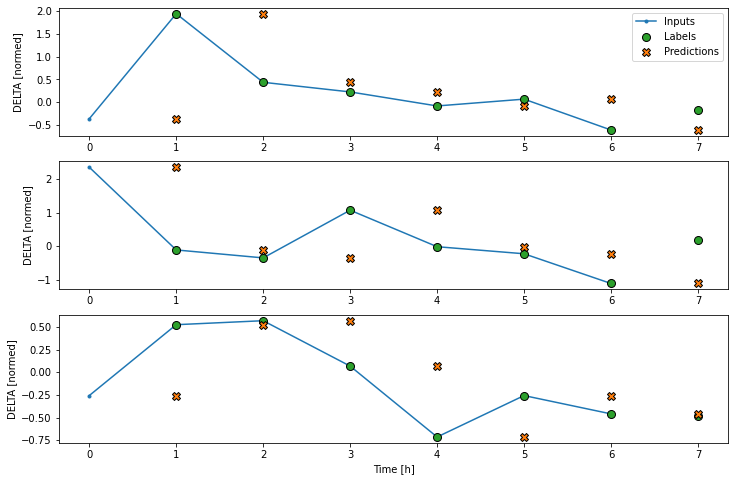

In [20]:
wide_window.plot(baseline)

##### Lineal

In [21]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [22]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [23]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 0s 15ms/step - loss: 3.9842 - mean_absolute_error: 1.5964 - val_loss: 4.2357 - val_mean_absolute_error: 1.7372
Epoch 2/20
9/9 [==============================] - 0s 8ms/step - loss: 3.8430 - mean_absolute_error: 1.5635 - val_loss: 3.9573 - val_mean_absolute_error: 1.6785
Epoch 3/20
9/9 [==============================] - 0s 8ms/step - loss: 3.6956 - mean_absolute_error: 1.5300 - val_loss: 3.7007 - val_mean_absolute_error: 1.6228
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 3.5590 - mean_absolute_error: 1.4985 - val_loss: 3.4596 - val_mean_absolute_error: 1.5690
Epoch 5/20
9/9 [==============================] - 0s 7ms/step - loss: 3.4344 - mean_absolute_error: 1.4675 - val_loss: 3.2248 - val_mean_absolute_error: 1.5144
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 3.3097 - mean_absolute_error: 1.4373 - val_loss: 3.0068 - val_mean_absolute_error: 1.4614
Epoch 7/20
9/9 [=======================

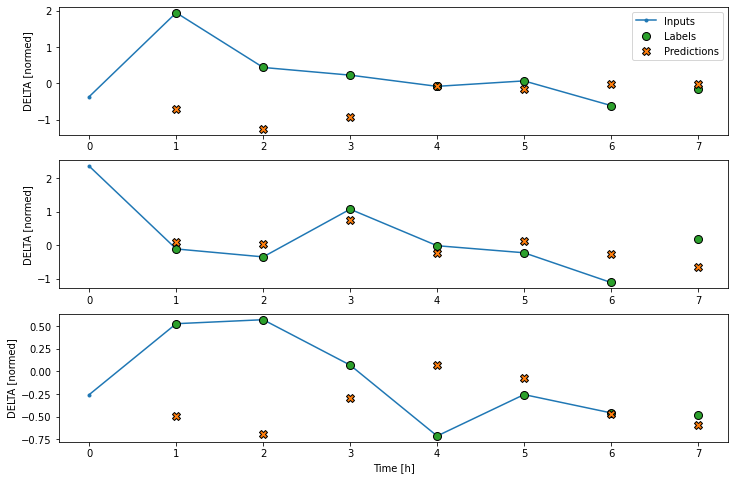

In [24]:
wide_window.plot(linear)

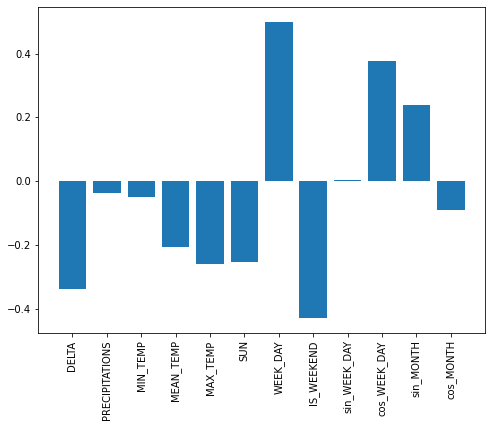

In [25]:
plt.bar(x = range(len(train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train.columns)))
_ = axis.set_xticklabels(train.columns, rotation=90)

##### Denso

In [26]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 1s 19ms/step - loss: 1.0639 - mean_absolute_error: 0.7885 - val_loss: 0.4960 - val_mean_absolute_error: 0.5630
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 0.9506 - mean_absolute_error: 0.7408 - val_loss: 0.5337 - val_mean_absolute_error: 0.5804
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.5477 - mean_absolute_error: 0.5797


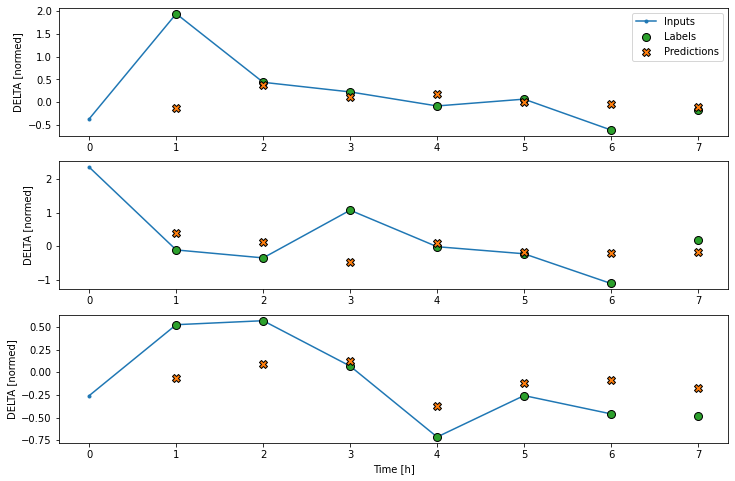

In [27]:
wide_window.plot(dense)

##### Denso de varios pasos

##### LSTM

In [28]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [29]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [41]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 2ms/step - loss: 1.8416 - mean_absolute_error: 0.9750


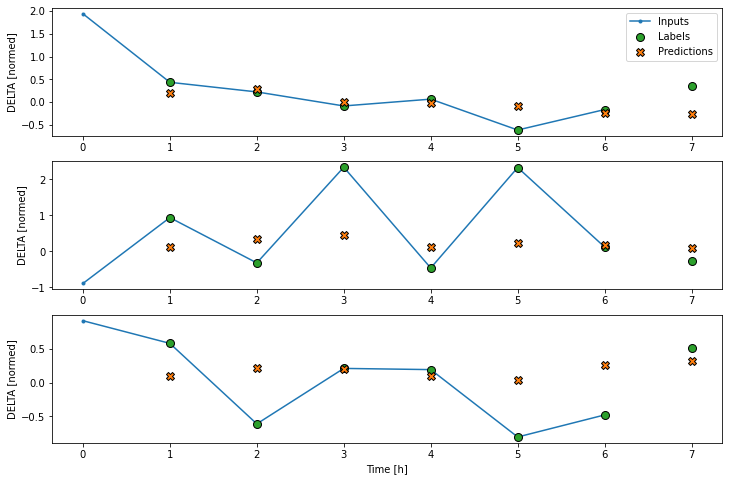

In [42]:
wide_window.plot(lstm_model)

In [43]:
performance

{'Baseline': [0.9623144268989563, 0.8192980885505676],
 'Linear': [1.1696408987045288, 0.9155688285827637],
 'Dense': [0.801274836063385, 0.7178301811218262],
 'LSTM': []}

### Training and scoring 

In [32]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=10
)

C:\Users\sergi\Anaconda3\envs\cajamar\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [33]:
model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
y_real = y_test

print('MSE:', mean_squared_error(y_real, y_pred))